<a href="https://colab.research.google.com/github/DanielhCarranza/Machine-Learning-in-Health/blob/master/Angle_Closure_Glaucoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Angle Closure Glaucoma
![](https://age.grand-challenge.org/media/cache/d3/44/d344b82abbd1926d1ba8c6d2b49edfed.png)
Glaucoma is the leading reason of irreversible blindness in the world. It is a disease involving both anterior and posterior segments of the eye. Abnormal anatomical structures of the chamber angle may cause elevated IOP and gradually leads to glaucomatous optic neuropathy. Such kind of condition is named as “primary angle-closure diseases” (PACD), which is the major type of glaucoma in Asia.

PACD patients have a characteristic structural difference from open-angle subjects in chamber angle and ocular biometric parameters, including narrow chamber angles, short axial length, thick lens, etc.

In clinical practice, we have various ways to image the angle structures: gonioscopy, ultrasonography, eyecam, optical coherence tomography (OCT), etc. Among them, gonioscopy is the gold standard in the classification of angle structure. Ophthalmologists grade angle width into different levels according to the angle structures seen under gonioscopy. However, gonioscopy is a contact examination and relies on ophthalmologists’ personal experience.

![](https://age.grand-challenge.org/media/i/bfd95707.jpg)

OCT provides us with non-contact imaging of the whole anterior chamber. In the old days, due to the limitation of scanning speed, only line scans of the anterior chamber could be obtained. With the invention of the swept-source light source, fast imaging of 3D anterior chamber structures became possible. OCT is able to clearly show the anatomical details of the chamber angle.

### OCT scanning protocol and manufacturers
The images available in this Challenge are acquired with CASIA I (SS-1000, Nagoya, Japan). SS-OCT examination was performed in a standardized darkroom with a light intensity of 0.16lux. The anterior chamber was divided into 128 meridians. 16 slices were extracted from each volume scan. Angle structure was classified into open, narrow, closure and unreadable. Gonioscopy was used as the reference standard. The scleral spur was localized on each side of the anterior chamber by 4 ophthalmologists independently.

## Clinical Significance
OCT examination is a fast and non-contact method to capture the morphology of the anterior chamber. We can easily identify open and narrow/closed angles based on OCT images. Besides, we could perform measurement of angle parameters, including angle open distance (AOD), trabecular iris space area (TISA), etc. Quantification of these parameters relies on the localization of specific mark — scleral spur (SS), which appears as a wedge projecting from the inner aspect of the anterior sclera in cross-sectional images. SS is attached anteriorly to the trabecular meshwork and posteriorly to the sclera and the longitudinal portion of the ciliary muscle.    

![](https://age.grand-challenge.org/media/i/7e1cbf59.jpg)

## Diagnostic Criteria and Ground-truth Annotation
Classification of angle width (open/closed) was based on gonioscopy by glaucoma experts. SS localization was determined by the mean of 4 independent annotations from a group of ophthalmologists, followed by a manual adjustment from a senior glaucoma expert.

### Resources
* [Challenge](https://age.grand-challenge.org/Background/)

### Setup

In [ ]:
! curl -L https://www.dropbox.com/s/xrd0rv0fi983j4z/Training100.zip?dl=1 > Training100.zip
! curl -L https://www.dropbox.com/s/yzpirfzvaiyht0x/Validation_ASOCT_Image.zip?dl=0 > Validation_ASOCT_Image.zip  

In [ ]:
! mkdir AC-Glaucoma
! unzip Training100.zip -d AC-Glaucoma  
! unzip Validation_ASOCT_Image.zip -d AC-Glaucoma

## EDA

In [ ]:
import os
import cv2 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.callbacks.hooks import *
from fastai.vision.interpret import SegmentationInterpretation

from torch.nn import L1Loss

from skimage import exposure
from sklearn.metrics import auc, roc_curve, precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

In [ ]:
path = Path('AC-Glaucoma')
path.ls()

[PosixPath('AC-Glaucoma/Validation_ASOCT_Image'),
 PosixPath('AC-Glaucoma/Training100')]

In [ ]:
train_path = (path/'Training100')
train_path.ls()

[PosixPath('AC-Glaucoma/Training100/Training100_Location.xlsx'),
 PosixPath('AC-Glaucoma/Training100/ASOCT_Image'),
 PosixPath('AC-Glaucoma/Training100/ASOCT_Illustration')]

In [ ]:
df= pd.read_excel(train_path/'Training100_Location.xlsx').set_index('ASOCT_Name')
df.head()

Left_Label          X1  ...           X2          Y2
ASOCT_Name                            ...                         
T0056-10.jpg           1  228.833656  ...  1870.803864  451.592300
T0047-06.jpg           1  207.935545  ...  1792.231404  432.521881
T0066-15.jpg           0  239.372633  ...  1899.775568  501.007410
T0025-15.jpg           0  177.708404  ...  1862.380363  439.228928
T0088-06.jpg           0  285.256170  ...  1884.122651  767.858589

[5 rows x 6 columns]

In [ ]:
img_f = (train_path/'ASOCT_Image').ls()[0]
img=open_image(img_f)
img.shape

torch.Size([3, 998, 2130])

In [ ]:
df.loc[img_f.name]

0.0

In [ ]:
(df['Left_Label']==df['Right_Label']).all()

True

## Classification

In [ ]:
get_labels= lambda x: int(df.loc[x.name][0])

In [ ]:
src= (ImageList.from_folder(train_path/'ASOCT_Image')
      .split_by_rand_pct()
      .label_from_func(get_labels))

def get_data(bs=64, size=256, **kwargs):
  return (src.transform(get_transforms(),size=size)
             .databunch(bs=bs)
             .normalize())

data= get_data(num_workers=4)

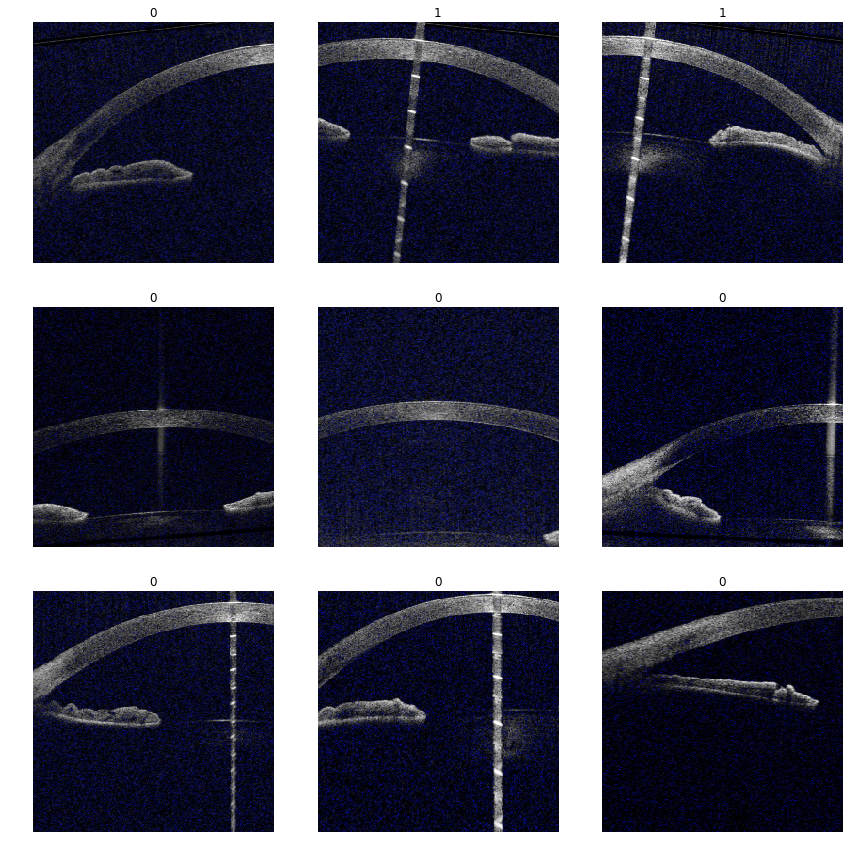

In [ ]:
data.show_batch(rows=3)

### Training

In [ ]:
cbfs = [partial(SaveModelCallback,every='epoch',name='res50_256'),
        ShowGraph]

In [ ]:
learner= cnn_learner(data, models.resnet50, metrics= [accuracy], callback_fns=cbfs)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 59678390.21it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


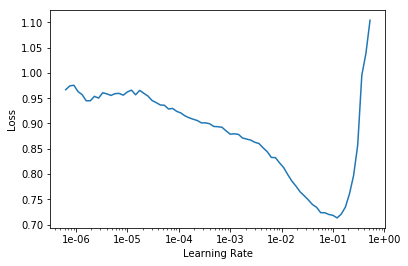

In [ ]:
learner.lr_find()
learner.recorder.plot()

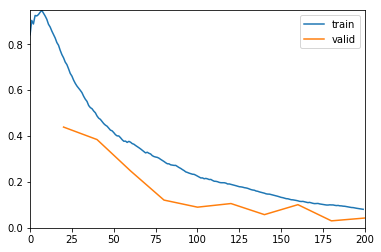

In [ ]:
lr= 1e-2
learner.fit_one_cycle(10, 2*lr)

In [ ]:
# learner.save('res50_256-98acc')
learner.export('models/res50_256-98acc.pkl')

In [ ]:
ls AC-Glaucoma/Training100/ASOCT_Image/models

res50_256_0.pth  res50_256_4.pth  res50_256_8.pth      res50_256_9.pth
res50_256_1.pth  res50_256_5.pth  res50_256-98acc      tmp.pth
res50_256_2.pth  res50_256_6.pth  res50_256-98acc.pkl
res50_256_3.pth  res50_256_7.pth  res50_256-98acc.pth


In [ ]:
path_local_models=(train_path/'ASOCT_Image')/'models'
stage_file ='res50_256-98acc.pth'
model_file ='res50_256-98acc.pkl'
upload_files_to_gcp(path_local_models/model_file, path_ophthalmology_models)
ls_gcp(path_ophthalmology_models)

Copying file://AC-Glaucoma/Training100/ASOCT_Image/models/res50_256-98acc.pkl [Content-Type=application/octet-stream]...
\
Operation completed over 1 objects/98.1 MiB.                                     
gs://medbotai/models/Ophthalmology/Angular_Closure_Glaucoma/res50_256-98acc.pkl
gs://medbotai/models/Ophthalmology/Angular_Closure_Glaucoma/res50_256-98acc.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


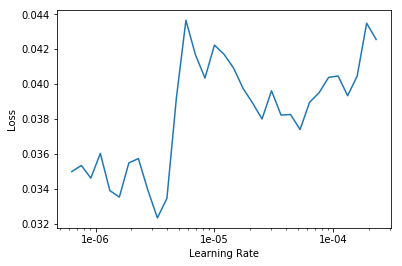

In [ ]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

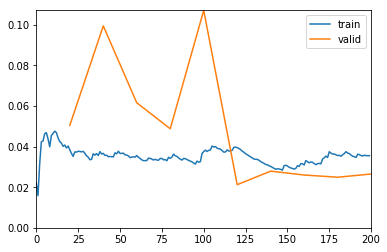

In [ ]:
learner.fit_one_cycle(10, slice(1e-5, 1e-4))

In [ ]:
learner.save('res50_256-99acc')
learner.export('models/res50_256-99acc.pkl')

In [ ]:
path_local_models=(train_path/'ASOCT_Image')/'models'
stage_file ='res50_256-99acc.pth'
model_file ='res50_256-99acc.pkl'
upload_files_to_gcp(path_local_models/stage_file, path_ophthalmology_models)
ls_gcp(path_ophthalmology_models)

Copying file://AC-Glaucoma/Training100/ASOCT_Image/models/res50_256-99acc.pth [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\
Operation completed over 1 objects/293.5 MiB.                                    
gs://medbotai/models/Ophthalmology/Angular_Closure_Glaucoma/res50_256-98acc.pkl
gs://medbotai/models/Ophthalmology/Angu

### Evaluation

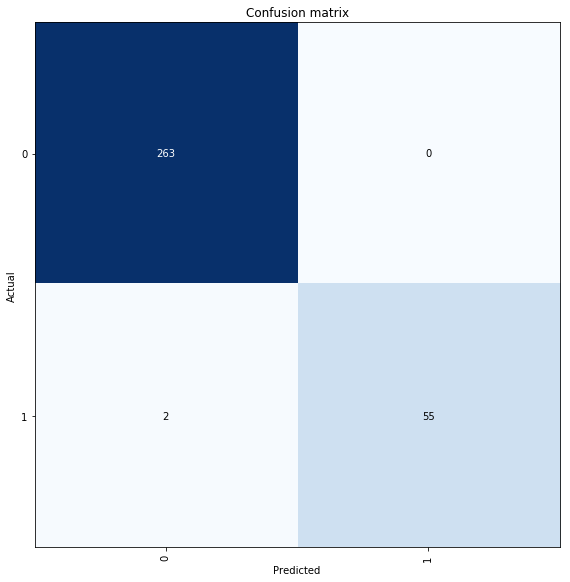

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(10,8))

In [ ]:
# Predictions of the validation data
preds, y_true=learner.get_preds()
y_true.shape, preds.shape

y_true=y_true.numpy() 
preds=np.argmax(preds.numpy(), axis=-1)
y_true.shape, preds.shape

((320,), (320,))

In [ ]:
# Generate a classification report

report = classification_report(y_true, preds)
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       263
           1       1.00      0.96      0.98        57

    accuracy                           0.99       320
   macro avg       1.00      0.98      0.99       320
weighted avg       0.99      0.99      0.99       320



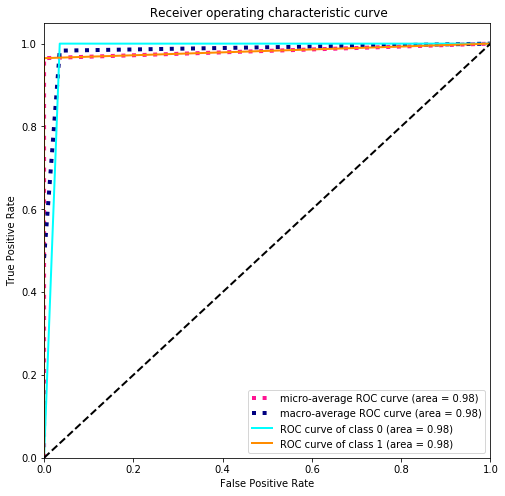

In [ ]:
from scipy import interp
from itertools import cycle

classes=[0,1]
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=len(classes)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_true))[:, i], np.array(pd.get_dummies(preds))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(np.array(pd.get_dummies(y_true))[:, i], np.array(pd.get_dummies(preds))[:, i])
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)


colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for c,i, color in zip(classes,range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(c, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

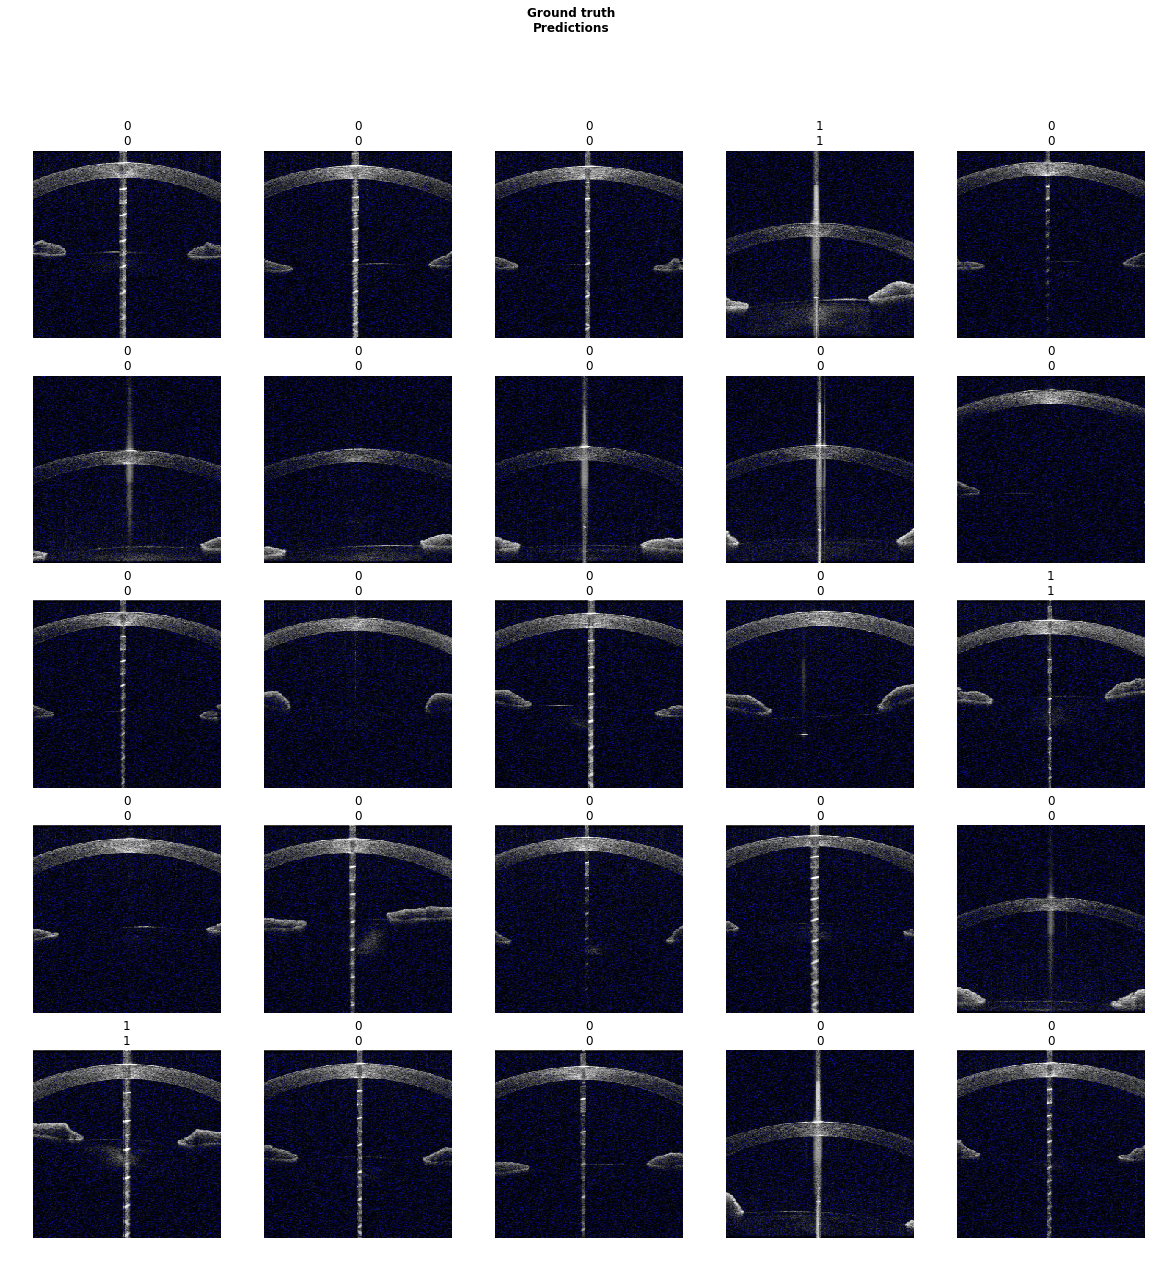

In [ ]:
learner.show_results()

## Localization

In [ ]:
df.head()

Left_Label          X1  ...           X2          Y2
ASOCT_Name                            ...                         
T0056-10.jpg           1  228.833656  ...  1870.803864  451.592300
T0047-06.jpg           1  207.935545  ...  1792.231404  432.521881
T0066-15.jpg           0  239.372633  ...  1899.775568  501.007410
T0025-15.jpg           0  177.708404  ...  1862.380363  439.228928
T0088-06.jpg           0  285.256170  ...  1884.122651  767.858589

[5 rows x 6 columns]

In [ ]:
pp=df.loc[img_f.name]
print(pp)
po=torch.tensor([[pp.X1,pp.Y1],
                 [pp.X2,pp.Y2]])
po

Left_Label        0.000000
X1              304.587866
Y1              698.578438
Right_Label       0.000000
X2             1958.543681
Y2              832.449767
Name: T0064-05.jpg, dtype: float64


tensor([[ 304.5879,  698.5784],
        [1958.5437,  832.4498]])

In [ ]:
pp[:,0] *= 256/im_height
pp[:,1] *= 256/im_width
pp

In [ ]:
def get_points(fn:Path):
  im_width, im_height = PIL.Image.open(fn).size
  coords= df.loc[fn.name]
  points= torch.tensor([[coords.Y1,coords.X1],
                       [coords.Y2,coords.X2]])
#   points[:,0] *= 256/im_height
#   points[:,1] *= 256/im_width
  return points 

In [ ]:
src=(PointsItemList.from_folder(train_path/'ASOCT_Image')
       .split_by_rand_pct()
       .label_from_func(get_points))


In [ ]:
src.train.y[0]

ImagePoints (998, 2130)

In [ ]:
def get_data_points(bs=32, size=256,**kwargs):
  return (src.transform(tfms=get_transforms(), size=size, tfm_y=True, resize_method=ResizeMethod.SQUISH, remove_out=False)
          .databunch(bs=bs, **kwargs)
          .normalize())

# dataP= get_data_points()


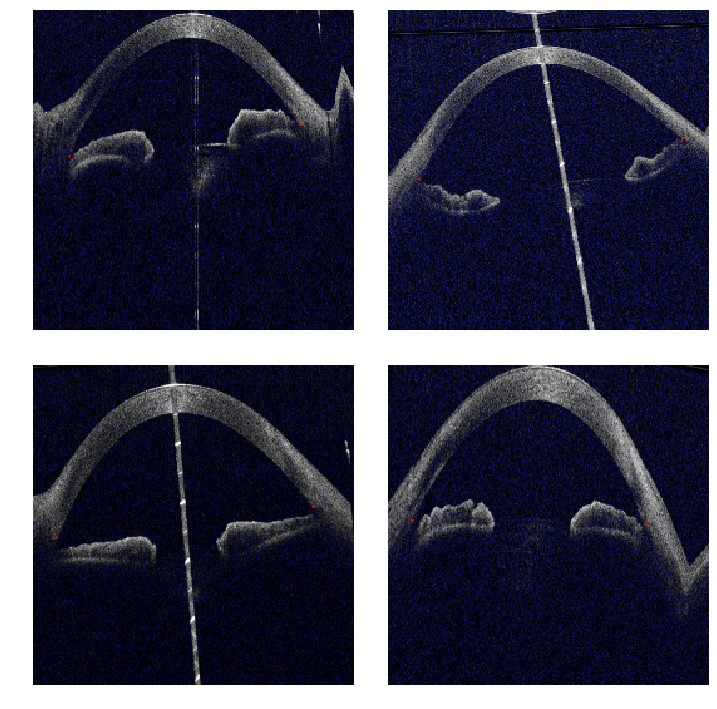

In [ ]:
dataP.show_batch(rows=2, figsize=(10,10))

### Model & Training

In [ ]:
class PointsDetector(nn.Module):
  def __init__(self, arch=models.resnet34, points_count=2,**kwargs):
    super().__init__()
    self.points_count= points_count
    self.cnn= create_body(arch)
    self.head=create_head(2*num_features_model(self.cnn), 2*points_count)
    
  def forward(self, img):
    bs = img.shape[0]
    x = self.cnn(img)
    x = self.head(x)
    activations = 2*(x.sigmoid_()-0.5)
    return activations.reshape(bs, self.points_count, 2)

In [ ]:
def loss_func(preds, targets): return L1Loss()(preds, targets)

def points_learner(data:DataBunch, model:Callable, loss_func=loss_func,init=nn.init.kaiming_normal_, **kwargs):
  learn = Learner(data, PointsDetector(arch=model), loss_func=loss_func, **kwargs)
  learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])
  if init: apply_init(learn.model, init)
  return learn

In [ ]:
cbfs = [partial(SaveModelCallback,every='epoch',name='points_res50_256'),
        ShowGraph]

learner= points_learner(dataP, models.resnet50, metrics=[mean_squared_error, root_mean_squared_error], callback_fns=cbfs )
# learner.freeze_to(-1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 89916201.78it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


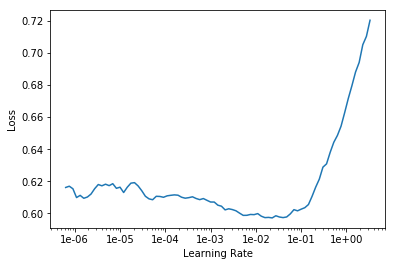

In [ ]:
learner.lr_find()
learner.recorder.plot()

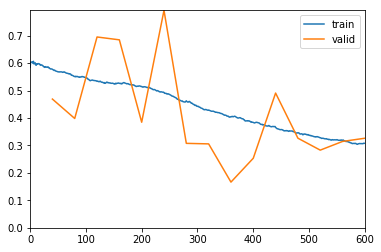

In [ ]:
lr = 1e-2
learner.fit_one_cycle(15, lr)

In [ ]:
learner.save('points_res50_256_32mse')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


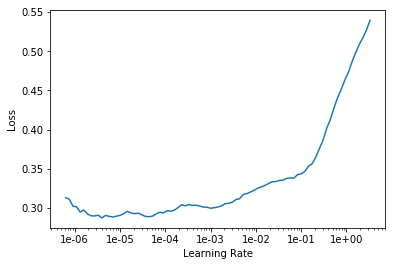

In [ ]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

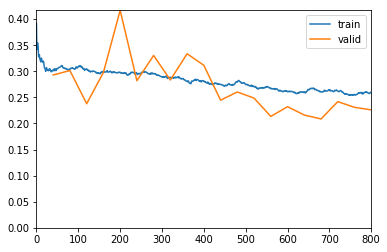

In [ ]:
learner.fit_one_cycle(20, slice(1e-5,1e-4, lr))

In [ ]:
learner.save('location_res50_256_16mse')
learner.export('models/location_res50_256_16mse.pkl')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type PointsDetector. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
path_local_models=(train_path/'ASOCT_Image')/'models'
stage_file ='location_res50_256_16mse.pth'
model_file ='location_res50_256_16mse.pkl'
upload_files_to_gcp(path_local_models/stage_file, path_ophthalmology_models)
ls_gcp(path_ophthalmology_models)

Copying file://AC-Glaucoma/Training100/ASOCT_Image/models/location_res50_256_16mse.pth [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

-
Operation completed over 1 objects/293.5 MiB.                                    
gs://medbotai/models/Ophthalmology/Angular_Closure_Glaucoma/location_res50_256_16mse.pkl
gs://medbotai/models/

In [ ]:
learner.load('location_res50_256_16mse')

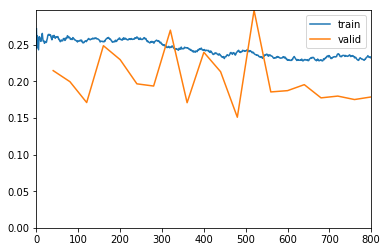

In [ ]:
learner.fit_one_cycle(20, slice(1e-5,1e-4, lr))

In [ ]:
learner.save('location_res50_256_10mse')
learner.export('models/location_res50_256_10mse.pkl')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type PointsDetector. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
path_local_models=(train_path/'ASOCT_Image')/'models'
stage_file ='location_res50_256_10mse.pth'
model_file ='location_res50_256_10mse.pkl'
# upload_files_to_gcp(path_local_models/model_file, path_ophthalmology_models)
download_files_from_gcp(path_ophthalmology_models+stage_file, path_local_models)
ls_gcp(path_ophthalmology_models)

Copying gs://medbotai/models/Ophthalmology/Angular_Closure_Glaucoma/location_res50_256_10mse.pth...
- [1/1 files][293.5 MiB/293.5 MiB] 100% Done                                    
Operation completed over 1 objects/293.5 MiB.                                    
gs://medbotai/models/Ophthalmology/Angular_Closure_Glaucoma/location_res50_256_10mse.pkl
gs://medbotai/models/Ophthalmology/Angular_Closure_Glaucoma/location_res50_256_10mse.pth
gs://medbotai/models/Ophthalmology/Angular_Closure_Glaucoma/location_res50_256_16mse.pkl
gs://medbotai/models/Ophthalmology/Angular_Closure_Glaucoma/location_res50_256_16mse.pth
gs://medbotai/models/Ophthalmology/Angular_Closure_Glaucoma/res50_256-98acc.pkl
gs://medbotai/models/Ophthalmology/Angular_Closure_Glaucoma/res50_256-98acc.pth
gs://medbotai/models/Ophthalmology/Angular_Closure_Glaucoma/res50_256-99acc.pkl
gs://medbotai/models/Ophthalmology/Angular_Closure_Glaucoma/res50_256-99acc.pth


In [ ]:
learner.load('location_res50_256_10mse')
# learner.fit_one_cycle(25, slice(1e-5,1e-4, lr), wd=1e-2)

#### 512

In [ ]:
dataP512=get_data_points(bs=16, size=512,num_workers=0)

In [ ]:
cbfs = [partial(SaveModelCallback,every='epoch',name='points_res50_256'),
        ShowGraph]

learner= points_learner(dataP512, models.resnet50, metrics=[mean_squared_error, root_mean_squared_error], 
                        callback_fns=cbfs ).load('location_res50_256_10mse')
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


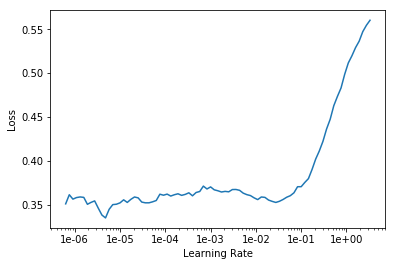

In [ ]:
learner.lr_find()
learner.recorder.plot()

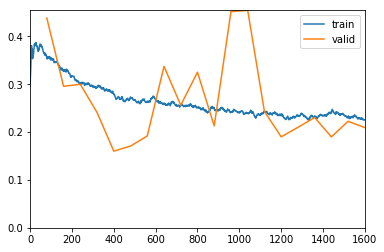

In [ ]:
lr = 1e-3
learner.fit_one_cycle(20, slice(1e-5,1e-4, lr))

In [ ]:
# learner.save('stage-1')
learner.load('stage-1')

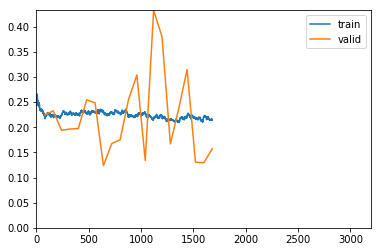

KeyboardInterrupt: ignored

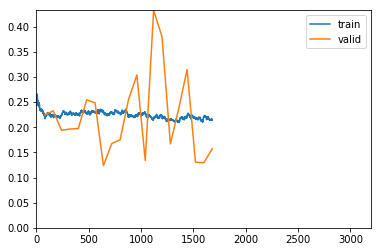

In [ ]:
lr = 1e-3
learner.fit_one_cycle(40, slice(1e-5,1e-4, lr))

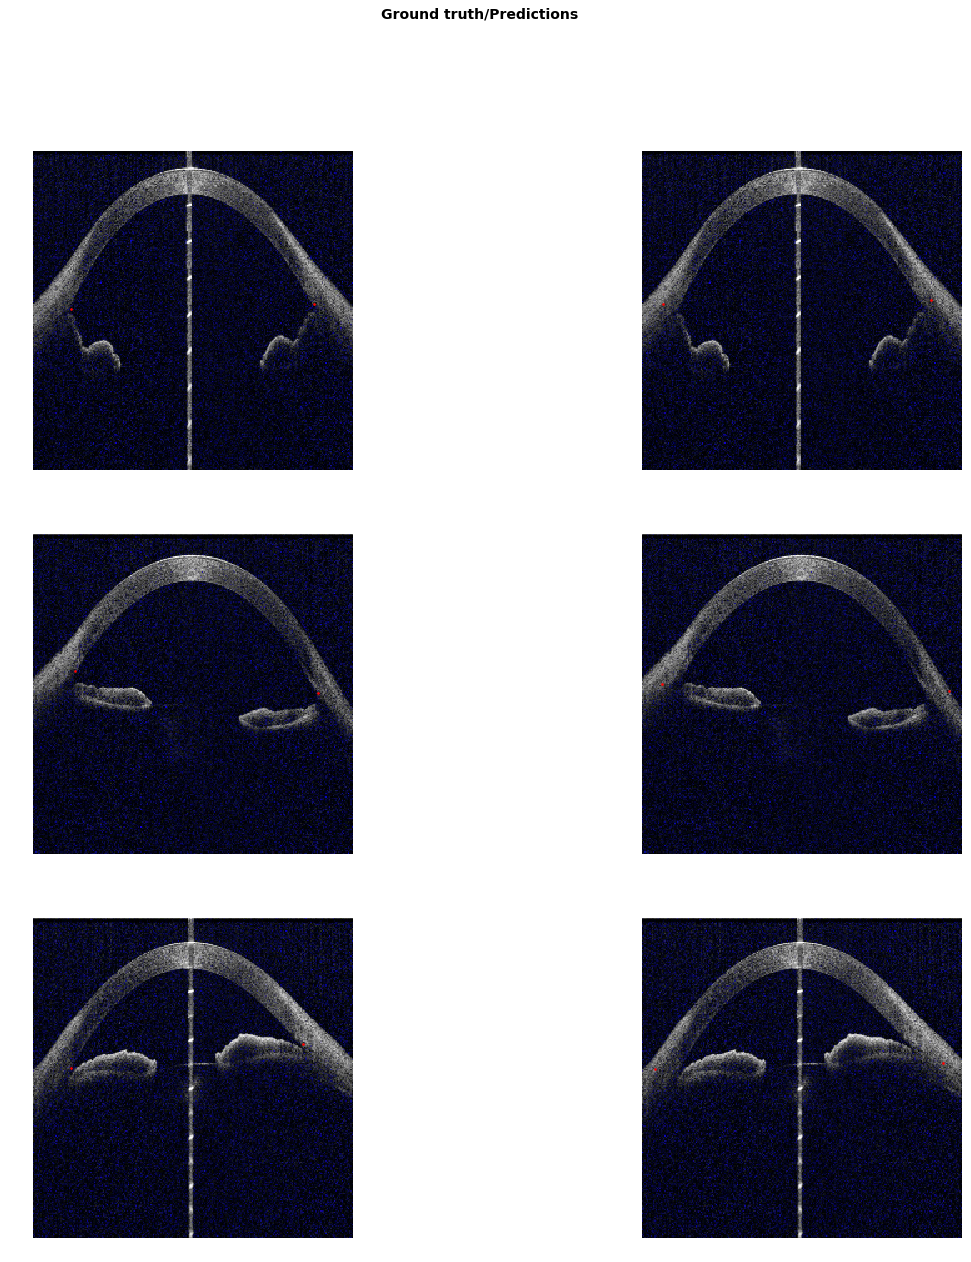

In [ ]:
learner.show_results(rows=3, figsize=(20,20))